In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
import math

In [2]:
def transform(data, const):
    return np.log(data + const)

def inverse_transform(data, const):
    return np.exp(data) - const

def stock_return(current_earning_yeld, predicted_earning_yeld,epsgr,pay_out_ratio):
    delta_cape = ((predicted_earning_yeld**-1)/(current_earning_yeld**-1))**(1/10) -1
    div_yeld = predicted_earning_yeld*pay_out_ratio
    return delta_cape+epsgr+div_yeld

In [3]:
path = "CAPE_ALL.xlsx"
df = pd.read_excel(path,sheet_name=0)
df["Date"] = pd.date_range(start='1871-01-01',end='2025-02-01',freq='ME')
df = df.dropna(subset=['CAPE'])
df.reset_index(drop=True, inplace=True)
df.head()

,Date,P,D,E,CPI,Fraction,Rate GS10,Real Price,Real Dividend,Real Total Return Price,Real Earnings,Scale Earnings,CAPE,TR CAPE,Yield,Monthly Bond Returns,Real Bond Returns,Stock Real Return 10 Yr,Bond Real Return 10 Yr,Returns
0,1881-01-31,6.19,0.265,0.4858,9.419420,1881.041667,3.700000,207.242891,8.872272,383.409300,16.264717,30.090507,18.473952,24.135057,-0.010489,1.003636,2.422306,0.045353,0.056468,-0.011115
1,1881-02-28,6.17,0.270,0.4817,9.514585,1881.125000,3.693333,204.507131,8.949259,379.727725,15.966140,29.645842,18.147258,23.655503,-0.011393,1.003631,2.406798,0.046774,0.056199,-0.009425
2,1881-03-31,6.24,0.275,0.4775,9.514585,1881.208333,3.686667,206.827309,9.114986,385.446207,15.826930,29.495283,18.270119,23.767713,-0.013123,1.003625,2.415537,0.042423,0.054885,-0.012462
3,1881-04-30,6.22,0.280,0.4733,9.609669,1881.291667,3.680000,204.124477,9.188883,381.836216,15.532494,29.055158,17.950108,23.308850,-0.007504,1.003620,2.400307,0.045971,0.054635,-0.008665
4,1881-05-31,6.50,0.285,0.4692,9.514585,1881.375000,3.673333,215.445114,9.446440,404.485199,15.551823,29.197609,18.869719,24.456686,-0.008881,1.003615,2.433070,0.041157,0.054786,-0.013628


In [4]:
from data_prep import DataProcessor 
processor = DataProcessor(df)

df["Bond_Returns_10Y"] = processor.get_real_bond_returns()
df["Nominal_Returns_10Y"] = processor.get_nominal_returns()

In [5]:
data = pd.DataFrame({})
data["Date"] = df["Date"]
data["CAPE_INV"] = 1/df["TR CAPE"]
data["CPI"] = df["CPI"].pct_change(periods=12).shift(2)
data["Bond_Returns_10Y"] = df["Bond_Returns_10Y"]
data["S&P Vol"] = df["P"].pct_change().rolling(12).std()
data["Inflation"] = df["CPI"].pct_change(12)  # NEEDS TO FIX THIS
data["Bond Vol"] = df["Real Bond Returns"].rolling(12).std()
data["ret10Y"] = df["Nominal_Returns_10Y"]
data["E"] = df["E"]
data["D"] = df["D"]
data["earnings_growth"] = (data['E']/data['E'].shift(120))**(1/10) - 1
data.set_index("Date",inplace=True)

0.03848653983718859


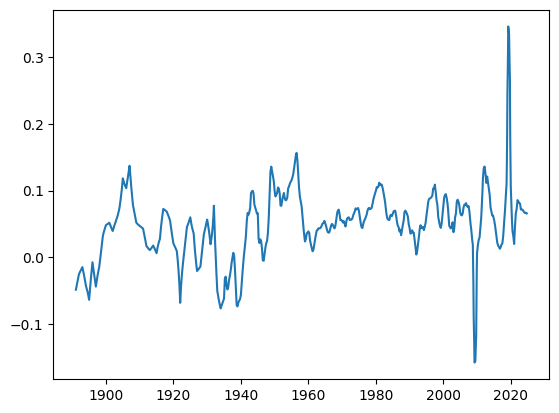

In [6]:
start_date = '1926-01-01'
end_date = '1970-12-31'
print(data["earnings_growth"][start_date:end_date].mean())

plt.plot(data["earnings_growth"])

In [7]:
var_names = ["CAPE_INV", "Bond_Returns_10Y", "Inflation", "S&P Vol", "Bond Vol" ]
# var_names = ["CAPE_INV", "Bond_Returns_10Y","S&P Vol", "Bond Vol" ]

const = [1e-6,0.06,0.20,0,0]
# const = [1e-6,0.06,0,0]

variables = transform(data.loc['1925-01-01':, var_names], const)

In [8]:
variables.tail()

,CAPE_INV,Bond_Returns_10Y,Inflation,S&P Vol,Bond Vol
Date,,,,,
2024-09-30,-3.647913,-3.097056,-1.494297,-3.678478,0.108826
2024-10-31,-3.673097,-3.222259,-1.487313,-3.954205,-0.055480
2024-11-30,-3.696419,-3.277205,-1.480632,-4.003966,-0.121044
2024-12-31,-3.709493,-3.321489,-1.477372,-4.108811,-0.139306
2025-01-31,-3.683805,-3.457973,-1.502706,-3.878262,-0.135823


In [9]:
# predicting 10 years ahead earnings

X = []
y = []

features = len(variables.columns)
features_name = variables.columns

data_train = variables['1925-01-01':'1969-12-31']
data_test = variables['1960-01-01':'2024-12-31']

lags = 12

for i in range(lags,len(data_train) - 120):
    X.append(data_train.iloc[i-lags:i,:]) # Jan 1926 - Dec 1959
    # X.append(data_train.iloc[i,:])
    y.append(data_train.iloc[i+120]["CAPE_INV"]) # Jan 1936 - Dec 1969

X = np.array(X).flatten().reshape(len(X),lags*features)
# X = np.array(X).flatten().reshape(len(X),lags*features)
len(data_train), len(X), len(y)

(540, 408, 408)

In [10]:
# data_test.head()

In [11]:
def train_model(model,X,y):
    X_test = data_train.iloc[-lags:,:].values.reshape(1,lags*features)
    y_pred = []
    y_actual = []
    curr_earnings = []
    dates = []

    model.fit(X, y)

    for i in range(lags,len(data_test) - 120):
        pred_y = model.predict(X_test)[0]

        y_pred.append(pred_y)
        y_actual.append(data_test.iloc[i - lags + 120]["CAPE_INV"])
        dates.append(data_test.index[i - lags + 120])
        curr_earnings.append(data_test.iloc[i-lags]["CAPE_INV"])

        
        # print(X_test.shape)
        # X_test = np.append(X_test[:,features:], np.array(data_test.iloc[i - lags]).reshape(1,-1) , axis=1)
        X_test = np.append(X_test[:,features:], np.array(data_test.iloc[i - lags]).reshape(1,-1) , axis=1)
        # model.fit(X_test, y_actual)

    # create a dataframe with the results
    results = pd.DataFrame({"Date":dates, "Actual":y_actual, "Predicted":y_pred, "Current": curr_earnings }) 

    results["Actual"] = inverse_transform(results["Actual"], const[0])
    results["Predicted"] = inverse_transform(results["Predicted"], const[0])
    results["Current"] = inverse_transform(results["Current"], const[0])

    results["Predicted_Returns"] = 0
    eps_growth = 0.07
    pay_out_ratio=0.61

    for i in range(len(results)):
        predicted_ey = results.loc[i,'Predicted']
        current_ey = results.loc[i,'Current']
        results.loc[i,"Predicted_Returns"] = stock_return(current_ey,predicted_ey,eps_growth,pay_out_ratio)

    return results     

def plot_cape_inv(results):
    plt.figure(figsize=(15,6))
    plt.plot(results["Date"], results["Actual"], label="Actual")
    plt.plot(results["Date"], results["Predicted"], label="Predicted")
    plt.plot(results["Date"], results["Current"], label="Current") 

def plot_returns(results):
    plt.plot(results["Date"], results["Predicted_Returns"], label="Predicted Returns")
    plt.plot(data['1970-01-01':'2023-12-31'].index, data['ret10Y']['1970-01-01':'2023-12-31'], label="Actual Returns")
    plt.legend()
    plt.show()
    from sklearn.metrics import mean_squared_error
    rmse = mean_squared_error(results["Predicted_Returns"], data['ret10Y']['1970-01-01':'2023-12-31']) ** 0.5
    print("RMSE: ", rmse)

In [12]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
results_rf = train_model(model,X,y)

C:\Users\Ishit\AppData\Local\Temp\ipykernel_19924\2535156610.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.07240025036847395' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results.loc[i,"Predicted_Returns"] = stock_return(current_ey,predicted_ey,eps_growth,pay_out_ratio)


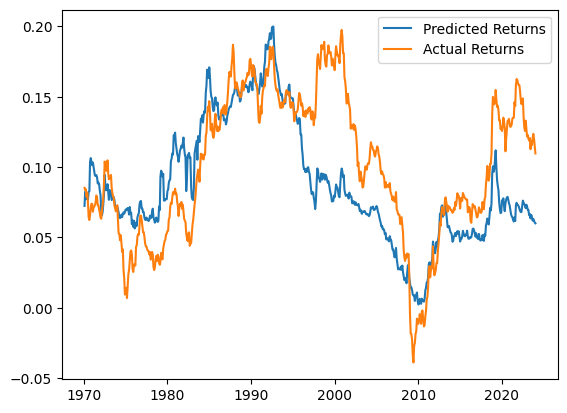

RMSE:  0.039804006784926814


648

In [13]:
# plt.plot(results_rf["Date"], results_rf["Actual"], label="Actual")
# plt.plot(results_rf["Date"], results_rf["Predicted"], label="Predicted")
plot_returns(results_rf)
len(results_rf)

C:\Users\Ishit\AppData\Local\Temp\ipykernel_19924\2535156610.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09161502633863546' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results.loc[i,"Predicted_Returns"] = stock_return(current_ey,predicted_ey,eps_growth,pay_out_ratio)


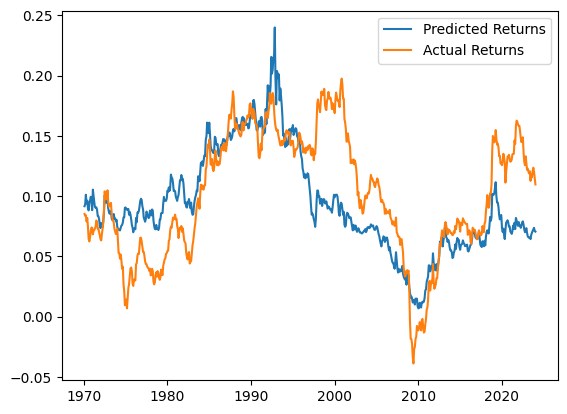

RMSE:  0.03885704202509469


In [14]:
# linear regression
from sklearn import linear_model
model = linear_model.LinearRegression()
results_lr = train_model(model,X,y)
plot_returns(results_lr)

C:\Users\Ishit\AppData\Local\Temp\ipykernel_19924\2535156610.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0752814531510356' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results.loc[i,"Predicted_Returns"] = stock_return(current_ey,predicted_ey,eps_growth,pay_out_ratio)


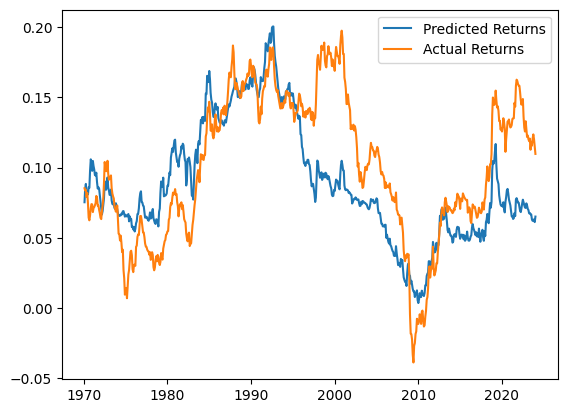

RMSE:  0.03800627761116443


In [15]:
# GBM
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=100, random_state=42)
results_gbm = train_model(model,X,y)
plot_returns(results_gbm)

C:\Users\Ishit\AppData\Local\Temp\ipykernel_19924\2535156610.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09890263127330312' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results.loc[i,"Predicted_Returns"] = stock_return(current_ey,predicted_ey,eps_growth,pay_out_ratio)


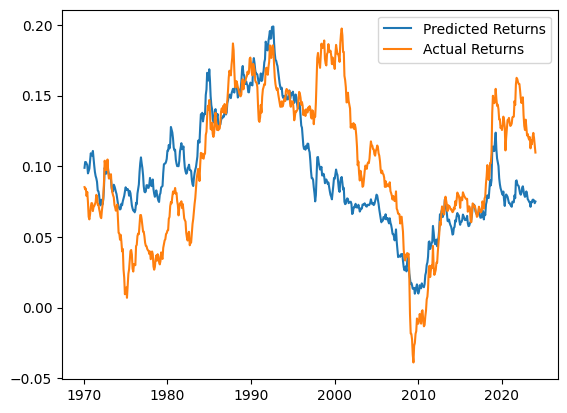

RMSE:  0.03854096759818357


In [16]:
# SVR
from sklearn.svm import SVR
model = SVR(kernel='rbf')
results_svr = train_model(model,X,y)
plot_returns(results_svr)

[]

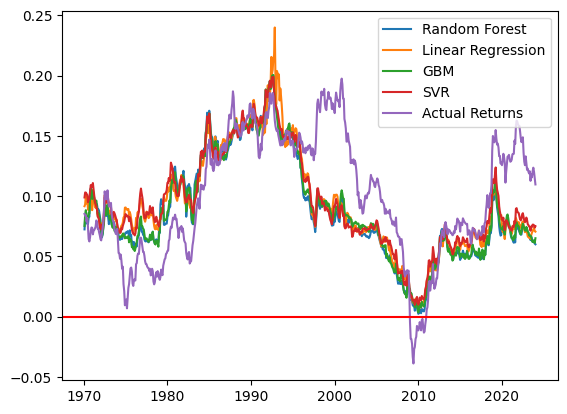

In [18]:
plt.plot(results_rf["Date"], results_rf["Predicted_Returns"], label="Random Forest")
plt.plot(results_lr["Date"], results_lr["Predicted_Returns"], label="Linear Regression")
plt.plot(results_gbm["Date"], results_gbm["Predicted_Returns"], label="GBM")
plt.plot(results_svr["Date"], results_svr["Predicted_Returns"], label="SVR")
plt.plot(data['1970-01-01':'2023-12-31'].index, data['ret10Y']['1970-01-01':'2023-12-31'], label="Actual Returns")
plt.axhline(y=0.0, color='r', linestyle='-')
plt.legend()
plt.plot()

In [43]:
# # rmse
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# rmse = mean_squared_error(results["Predicted_Returns"], data['ret10Y']['1970-01-01':'2023-12-31'])
# sqrt(rmse)

In [44]:
# predicted_earnings = []
# predicted_div = []




# # growth_m = data[start_date:end_date]["E"].pct_change().mean()
# growth_y = data["earnings_growth"][start_date:end_date].mean()
# payout_ratio = (data["D"][start_date:end_date]/data["E"][start_date:end_date]).median()
# print(growth_y,payout_ratio)